# Image Processing

In [37]:
import numpy as np
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
#from random import randrange
import cv2 

### Image helper ###

In [38]:
def image_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
def get_image(i_dim, n_dim, n_pos , n_strength, pos_scale):
    image = torch.zeros((3, i_dim,i_dim))
    if isinstance(n_pos, torch.Tensor):
        i_n_pos = (n_pos * pos_scale).type(torch.int)
    else:
        i_n_pos = (n_pos * pos_scale).astype(int)
    #print(i_n_pos[0])
    for c in range(3): #to get it equal over all chanels 
        image[c, i_n_pos[0].item():(i_n_pos[0].item() + n_dim),i_n_pos[1].item():(i_n_pos[1].item()+n_dim)] = n_strength
    return image
def net_show(n_pos, i_dim=64, n_dim=3, n_strength=torch.ones((3,3)), pos_scale=62):
    with torch.no_grad():
        npn_pos = n_pos.numpy()
        npn_pos = np.transpose(npn_pos, (1,2,0))
        for batch in npn_pos:
            red_n_pos = np.array([batch[0][0], batch[1][0]])
            print(red_n_pos)
            image = get_image(i_dim, n_dim, red_n_pos, n_strength, pos_scale)
            image_show(image)

### Dataset helper

In [39]:
i_dim = 64
n_dim = 3

dataset_parameter = {
    "train": ("./pixel_finder_train_data.pth", 2000), 
    "test": ("./pixel_finder_test_data.pth", 500),
    "validate": ("./pixel_finder_validate_data.pth",500)}


In [40]:
class ImagePositionDataset(Dataset):
    def __init__(self, i_dim, n_dim, sample_size, path=""):
        self.i_dim = i_dim
        self.n_dim = n_dim
        self.pos_scale = i_dim-n_dim+1
        if path != "": #load the data
            self.load(path, i_dim, n_dim)
            assert sample_size == self.sample_size
        else: #create new data
            self.sample_size = sample_size
            self.data = []
            for i in range(sample_size):
                n_pos = torch.flatten(torch.rand((1,2)))
                n_strength = torch.rand((3,3))#np.random.rand(n_dim, n_dim) #one chanel
                self.data.append((n_pos, n_strength))
        
    def __len__(self):
        return self.sample_size
    
    def __getitem__(self, idx):
        sample = (get_image(i_dim, n_dim, self.data[idx][0], self.data[idx][1], self.pos_scale), self.data[idx][0], self.pos_scale)
        return sample
    
    def save(self, path):
        torch.save(self.data, path)
        
    def load(self, path, i_dim, n_dim):
        self.data = torch.load(path)
        self.sample_size = len(self.data)
        
        


### Create Dataset

In [41]:
#new dataset
dataset = {}
dataloader = {}
for name, parameter in dataset_parameter.items():
    dataset[name] = ImagePositionDataset(i_dim, n_dim, parameter[1])
    dataset[name].save(parameter[0])
    dataloader[name] = DataLoader(dataset[name], batch_size=4,
                        shuffle=True, num_workers=0)


### Load Dataset

In [10]:
dataset = {}
dataloader = {}
for name, parameter in dataset_parameter.items():
    dataset[name] = ImagePositionDataset(i_dim, n_dim, parameter[1], path=parameter[0])
    dataloader[name] = DataLoader(dataset[name], batch_size=4,
                        shuffle=True, num_workers=0)

### Test Dataset

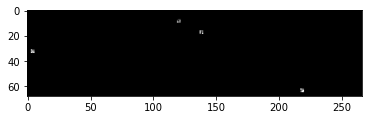

In [42]:
dataiter = iter(dataloader["train"])
images, labels, scales = dataiter.next()
image_show(torchvision.utils.make_grid(images))

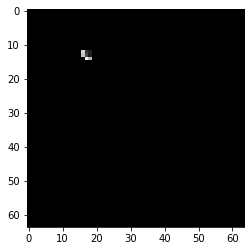

In [43]:
image,_,_ = dataset["train"][0]
image_show(image)

### Test net on selected data

In [ ]:
net(images) 
#net(image.unsqueeze(0));


## Create the net

In [47]:
net_path = {}
net = {}

### Net helper

In [44]:
def getNetPath(net_choice, epoch, learnrate, original=False):
    if original:
        return f"{net_path[net_choice]}.pth"
    return f"{net_path[net_choice]}_lr_{learnrate}_ep_{epoch}.pth" 

### Convolution ####

In [32]:
net_path["conv"] = './pixel_finder_conv'

In [20]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
    
    
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))



class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = ResNetLayer(3, 16, block=ResNetBasicBlock, n=2)
        self.fc1 = nn.Linear(32*32*16 , 1024)
        self.fc2 = nn.Linear(1024,2)
        self.sig = nn.Sigmoid()
        self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.sig(out)
        
        return out


net["conv"] = Net()

### Linear ###

In [56]:
net_path["linear"] = './pixel_finder_linear'

In [59]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(i_dim*i_dim*3, i_dim*i_dim*3)
        self.fc2 = nn.Linear(i_dim*i_dim*3,2)
        #self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


net["linear"] = LinearNet()

### Select the net

In [49]:
net_choice = "linear"

## Train the net

In [52]:
hyperparameter = {
    "learnrate" : (0.01,0.1),
    "epoch" : (2,4)}


### Loss, optimization criterion, optimization algorithm

In [60]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = {}
for lr in hyperparameter["learnrate"]:
    optimizer[lr] = torch.optim.Adam(net[net_choice].parameters(), lr=lr)

### Trainingsloop

In [54]:
#output every running_loss_count
running_loss_count = 50
metrics = {"running_loss" : [],
          "validation_loss": []}

In [ ]:
# save starting net
torch.save(net[net_choice].state_dict(), getNetPath(net_choice, 0,0, original=True))

for num_epoch in hyperparameter["epoch"]:
    for learnrate in hyperparameter["learnrate"]:
        #load the original net to start from the same parameters
        net[net_choice].load_state_dict(torch.load(getNetPath(net_choice, 0,0, original=True)))
        net[net_choice].train()
        print(f"Calculate the net with {num_epoch} epochs and a learning rate of {learnrate}")
        for epoch in range(num_epoch):
            loss_running = 0.0
            for i_batch, sample_batched in enumerate(dataloader["train"]):
                inputs, labels, _ = sample_batched
                
                #reset calculated gradients
                optimizer[learnrate].zero_grad()
                
                #calculate the output and loss
                outputs = net[net_choice](inputs)
                loss = loss_fn(outputs, labels)
                
                #backpropagate loss and optimize parameter
                loss.backward()
                optimizer[learnrate].step()
                
                #track loss
                loss_running += loss.item()
                if i_batch % running_loss_count == running_loss_count -1:
                    print(f"(Epoch {epoch + 1}, batch {i_batch + 1}): {loss_running/running_loss_count}")
                    metrics["running_loss"].append(loss_running)
                    loss_running = 0.0
        #save the trained net
        torch.save(net[net_choice].state_dict(), getNetPath(net_choice, epoch,learnrate))
        
        #do the validation
        net[net_choice].eval()
        with torch.no_grad():
            loss_running = 0.0
            for i_batch, sample_batched in enumerate(dataloader["validate"]):
                inputs, labels, _ = sample_batched
                
                #calculate the output and loss
                outputs = net[net_choice](inputs)
                loss = loss_fn(outputs, labels)
                
                #track loss
                loss_running += loss.item()
                if i_batch % running_loss_count == running_loss_count -1:
                    print(f"(Batch {i_batch + 1}): {loss_running/running_loss_count}")
                    metrics["validation_loss"].append(loss_running)
                    loss_running = 0.0
            
print('Finished Training')

Calculate the net with 2 epochs and a learning rate of 0.01
(Epoch 1, batch 50): 22.06590925335884


## Metriken

### Bias 